<img src='https://kabardewata.com/uploads/image/news_agustus/bumbu-bali-restaurant.jpg' style='width:100%; position:absolute;'>
<h1 style='text-align:center; font-size:100px; position:relative; opacity:0.9; padding-top:200px;'>THE BATTLE OF NEIGHBORHOODS</h1>

# INTRODUCTION: BUSINESS PROBLEM

IN THIS PROJECT, WE TRY TO FINDING SOLUTION FOR A CHEFF WHO WANT TO OPEN RESTAURANT
HE DONT KNOW WHICH PLACE THAT HAVE MOST STRATEGIC LOCATION, SO THE CHEF CONTACT US AS DATA SCIENTIST TO SOLVE HIS BUSINESS PROBLEM AND GET INSIGHT ABOUT LOCATION TO OPEN HIS RESTAURANT


# DATA

the data that we will use are:
<ol>
<li>number of worker and company in every regency by <a href='https://bali.bps.go.id/statictable/2019/10/09/161/jumlah-perusahaan-dan-tenaga-kerja-industri-besar-dan-sedang-menurut-kabupaten-kota-di-bali-2018.html'>Bali Statistics Agency</a></li>
<li>Regency list of bali from <a href='https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali'>wikpedia</a></li>
<li><a href='https://developer.foursquare.com/'>Foursquare</a> API to find any recommended restaurant</li>
</ol>

data above will be crawling, understanding and cleaning to get insight about our business problem

In [341]:
#import module that used

from bs4 import BeautifulSoup   #for formatting web
import requests #for request web page
import pandas as pd #for data manipulation and analytic
from matplotlib import pyplot as plt #visualization
import re #for formatting
from geopy.geocoders import Nominatim   #for find coordinate
import folium   #for visualization
pd.set_option('display.max_columns', None)

# 1.1 EDA ON WIKIPEDIA DATA

In [264]:
#request web page then format it 
url = 'https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali'
response    = requests.get(url)
soup    = BeautifulSoup(response.text, 'lxml')

In [265]:
#search table section

table   = soup.find('table')

In [266]:
#create empty list and iterate every row on table then append it to the list and create dataframe

regency = []
cgoverm = []
mayor   = []
area    = []
populat = []
subdist = []
village = []

for row in table.findAll('tr'):
    col = row.findAll('td')
    if len(col) == 10:
        regency.append(col[1].find(text=True))
        cgoverm.append(col[2].find(text=True))
        mayor.append(col[3].find(text=True))
        area.append(col[4].find(text=True).replace('\n',''))
        populat.append(col[5].find(text=True))
        subdist.append(col[6].find(text=True))
        village.append(col[7].find(text=True))        

dataframe   = { 'regency':regency,
                'central goverment':cgoverm,
                'mayor':mayor,
                'area (KM2)':area,
                'population (2017)':populat,
                'sub district':subdist,
                'village':village}

bali    = pd.DataFrame(dataframe)

In [267]:
#check dataframe
bali

,regency,central goverment,mayor,area (KM2),population (2017),sub district,village
0,Kabupaten Badung,Mangupura,I Nyoman Giri Prasta,"418,62",468.346,6,16/46
1,Kabupaten Bangli,Bangli,I Made Gianyar,"490,71",264.945,4,4/68
2,Kabupaten Buleleng,Singaraja,Putu Agus Suradnyana,"1.364,73",814.356,9,19/129
3,Kabupaten Gianyar,Gianyar,I Made Agus Mahayastra,"368,00",492.757,7,6/64
4,Kabupaten Jembrana,Negara,I Putu Artha,"841,80",323.211,5,10/41
5,Kabupaten Karangasem,Amlapura,I Gusti Ayu Mas Sumatri,"839,54",545.389,8,3/75
6,Kabupaten Klungkung,Semarapura,I Nyoman Suwirta,"315,00",215.852,4,6/53
7,Kabupaten Tabanan,Tabanan,Ni Putu Eka Wiryastuti,"1.013,88",466.647,10,-/133
8,Kota Denpasar,-,Ida Bagus Rai Dharmawijaya Mantra,"127,78",638.548,4,16/27


In [268]:
#change central goverment on kota denpasar

bali['central goverment'][8] = 'Denpasar'

In [269]:
bali

,regency,central goverment,mayor,area (KM2),population (2017),sub district,village
0,Kabupaten Badung,Mangupura,I Nyoman Giri Prasta,"418,62",468.346,6,16/46
1,Kabupaten Bangli,Bangli,I Made Gianyar,"490,71",264.945,4,4/68
2,Kabupaten Buleleng,Singaraja,Putu Agus Suradnyana,"1.364,73",814.356,9,19/129
3,Kabupaten Gianyar,Gianyar,I Made Agus Mahayastra,"368,00",492.757,7,6/64
4,Kabupaten Jembrana,Negara,I Putu Artha,"841,80",323.211,5,10/41
5,Kabupaten Karangasem,Amlapura,I Gusti Ayu Mas Sumatri,"839,54",545.389,8,3/75
6,Kabupaten Klungkung,Semarapura,I Nyoman Suwirta,"315,00",215.852,4,6/53
7,Kabupaten Tabanan,Tabanan,Ni Putu Eka Wiryastuti,"1.013,88",466.647,10,-/133
8,Kota Denpasar,Denpasar,Ida Bagus Rai Dharmawijaya Mantra,"127,78",638.548,4,16/27


In [270]:
#remove Kabupaten and Kota in dataframe & . on number column

bali['regency'] = bali['regency'].str.replace('Kabupaten','')
bali['regency'] = bali['regency'].str.replace('Kota','')

bali['area (KM2)'] = bali['area (KM2)'].str.replace('.','')
bali['area (KM2)'] = bali['area (KM2)'].apply(lambda x: re.match('[0-9]+',x).group())

bali['population (2017)'] = bali['population (2017)'].str.replace('.','')

bali['area (KM2)'] = bali['area (KM2)'].astype('int64')
bali['population (2017)'] = bali['population (2017)'].astype('int64')


In [271]:
#create new feature named density
bali['density (population / m2)'] = bali['population (2017)'] / (bali['area (KM2)']*1000)#convert km to m

#sort dataframe by density
bali.sort_values('density (population / m2)', ascending=False, inplace=True)

In [272]:
temp

,regency,central goverment,mayor,area (KM2),population (2017),sub district,village,density (population / m2)
2,Buleleng,Singaraja,Putu Agus Suradnyana,1364,814356,9,19/129,0.597035
8,Denpasar,Denpasar,Ida Bagus Rai Dharmawijaya Mantra,127,638548,4,16/27,5.027937
5,Karangasem,Amlapura,I Gusti Ayu Mas Sumatri,839,545389,8,3/75,0.650046
3,Gianyar,Gianyar,I Made Agus Mahayastra,368,492757,7,6/64,1.339014
0,Badung,Mangupura,I Nyoman Giri Prasta,418,468346,6,16/46,1.120445
7,Tabanan,Tabanan,Ni Putu Eka Wiryastuti,1013,466647,10,-/133,0.460658
4,Jembrana,Negara,I Putu Artha,841,323211,5,10/41,0.384317
1,Bangli,Bangli,I Made Gianyar,490,264945,4,4/68,0.540704
6,Klungkung,Semarapura,I Nyoman Suwirta,315,215852,4,6/53,0.685244


In [293]:
(temp['population (2017)'] / sum(temp['population (2017)']))

2    0.192517
8    0.150955
5    0.128932
3    0.116490
0    0.110719
7    0.110317
4    0.076408
1    0.062634
6    0.051028
Name: population (2017), dtype: float64

In [292]:
(bali['density (population / m2)'] / sum(bali['density (population / m2)']))

8    0.465317
3    0.123921
0    0.103693
6    0.063417
5    0.060159
2    0.055253
1    0.050040
7    0.042632
4    0.035567
Name: density (population / m2), dtype: float64

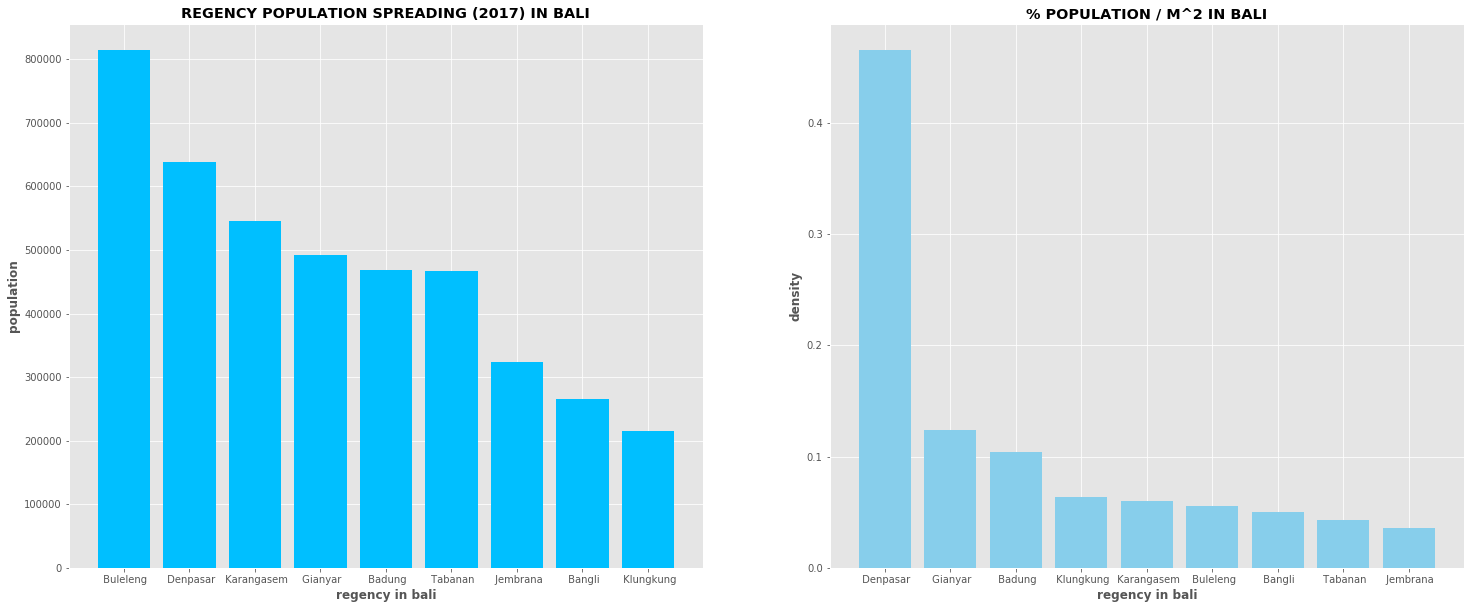

In [336]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=[25,10], ncols=2)

#visualize population
temp    = bali.sort_values('population (2017)', ascending=False)
ax[0].bar(temp['regency'], temp['population (2017)'], color='deepskyblue')
ax[0].set_xlabel('regency in bali', fontweight='bold')
ax[0].set_ylabel('population', fontweight='bold')
ax[0].set_title('REGENCY POPULATION SPREADING (2017) IN BALI', fontweight='bold')


#visualize density in regency
ax[1].bar(bali['regency'], (bali['density (population / m2)'] / sum(bali['density (population / m2)'])), color='skyblue')
ax[1].set_xlabel('regency in bali', fontweight='bold')
ax[1].set_ylabel('density', fontweight='bold')
ax[1].set_title('% POPULATION / M^2 IN BALI', fontweight='bold')


plt.show()

# 1.2 EDA ON WORKER DATA

In [306]:
worker  = pd.read_excel('data/pekerja.xlsx', skiprows=5)
worker

,Unnamed: 0,Establishment,Worker,Establishment.1,Worker.1,Establishment.2,Worker.2
0,Jembrana,5.0,1901.0,18.0,704.0,23.0,2605.0
1,Tabanan,6.0,833.0,21.0,1076.0,27.0,1909.0
2,Badung,17.0,4467.0,44.0,1840.0,61.0,6307.0
3,Gianyar,9.0,1693.0,40.0,1627.0,49.0,3320.0
4,Klungkung,0.0,0.0,18.0,785.0,18.0,785.0
5,Bangli,2.0,276.0,5.0,145.0,7.0,421.0
6,Karangasem,0.0,0.0,7.0,364.0,7.0,364.0
7,Buleleng,2.0,313.0,13.0,495.0,15.0,808.0
8,Denpasar,21.0,7916.0,120.0,5039.0,141.0,12955.0
9,Jumlah / Total :,62.0,17399.0,286.0,12075.0,348.0,29474.0


In [317]:
worker.rename(columns= {'Unnamed: 0': 'regency', 
                        'Establishment': 'large industry', 'Worker':'li_Worker', 'Establishment.1': 'medium industry', 'Worker.1':'me_industry',
       'Establishment.2': 'total industry', 'Worker.2': 'total worker'}, inplace=True)

worker  = worker[0:9]

In [320]:
for i in worker.select_dtypes(include=['float64']):
    worker[i] = worker[i].astype('int64')

In [323]:
worker.sort_values('total worker', ascending=False, inplace=True)

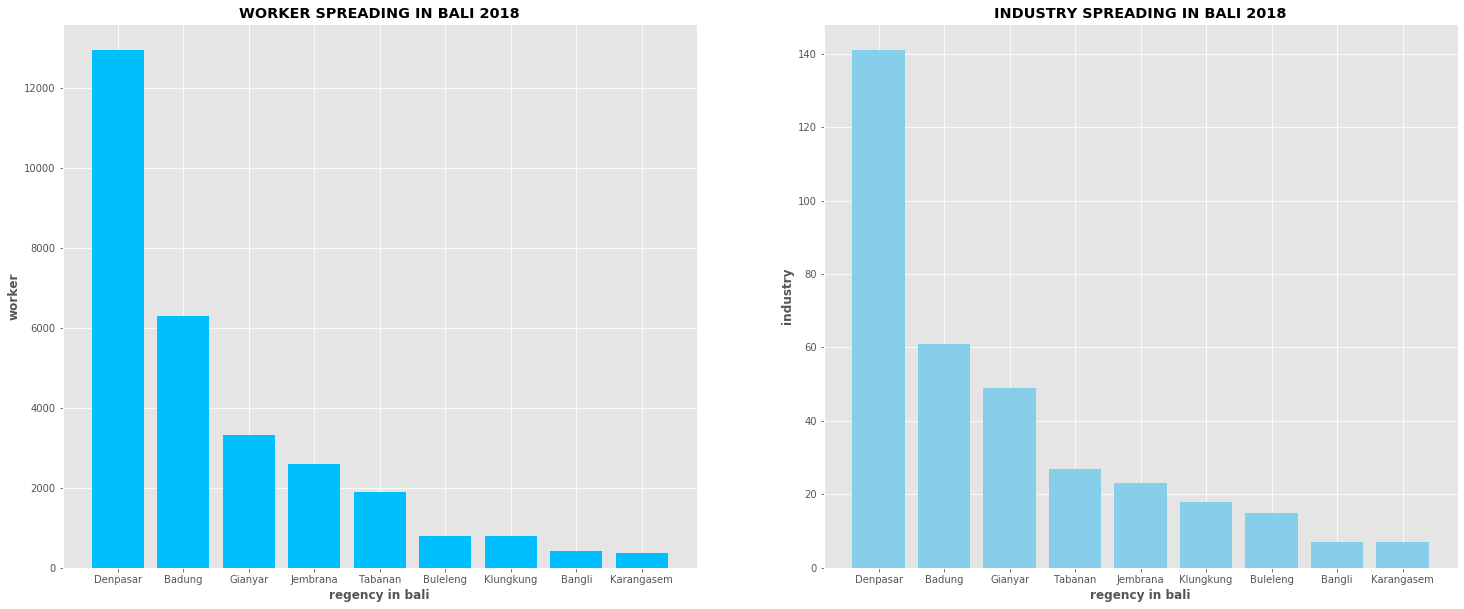

In [337]:
fig, ax = plt.subplots(figsize=[25,10], ncols=2)

ax[0].bar(worker['regency'], worker['total worker'], color='deepskyblue')
ax[0].set_xlabel('regency in bali', fontweight='bold')
ax[0].set_ylabel('worker', fontweight='bold')
ax[0].set_title('WORKER SPREADING IN BALI 2018', fontweight='bold')


temp = worker.sort_values('total industry', ascending=False)
ax[1].bar(temp['regency'], temp['total industry'], color='skyblue')
ax[1].set_xlabel('regency in bali', fontweight='bold')
ax[1].set_ylabel('industry', fontweight='bold')
ax[1].set_title('INDUSTRY SPREADING IN BALI 2018', fontweight='bold')

plt.show()

NOW WE KNOW THAT DENPASAR IS THE MOST STRATEGIC REGENCY TO OPEN RESTAURANT, THE CONSIDERATION WE TAKE ARE DENSITY OF POPULATION AND INDUSTRY SPREADING IN REGENCY IS LEANING TO DENPASAR

In [374]:
eolocator   = Nominatim(user_agent='coursera_assignment')
location    = geolocator.geocode('Denpasar, Bali')

denpasar    = folium.Map([location.latitude, location.longitude], zoom_start=13, min_zoom=13, max_zoom=13)

folium.CircleMarker(
    [location.latitude, location.longitude],
    radius=350,
    fill=True,
    fill_color='#00bfff',
    fill_opacity=0.2,
    parse_html=False
    ).add_to(denpasar)
denpasar    

## LETS FIND OUT ANY RECOMMENDATION RESTAURANT IN DENPASAR